# Homework 2: Question Answering on Squad
## EECS 498/598 Winter 2024

Homework Submission Due: Friday, Feburary 23, 11:59pm
Please submit both pdf and ipynb files of this note book on Gradescope and make sure your code can be run without bugs.

# Overview
---
In this project you will develop NLP models for question-answering tasks. Specifically, you will train models on the SQuAD 2.0 dataset which contains questions on text segments from Wikipedia. The dataset aims to measure the reading comprehension capabilities of machines. Some examples from the main paper are given below. For this assignment, the task is finetuning a BERT-like model on the dataset.

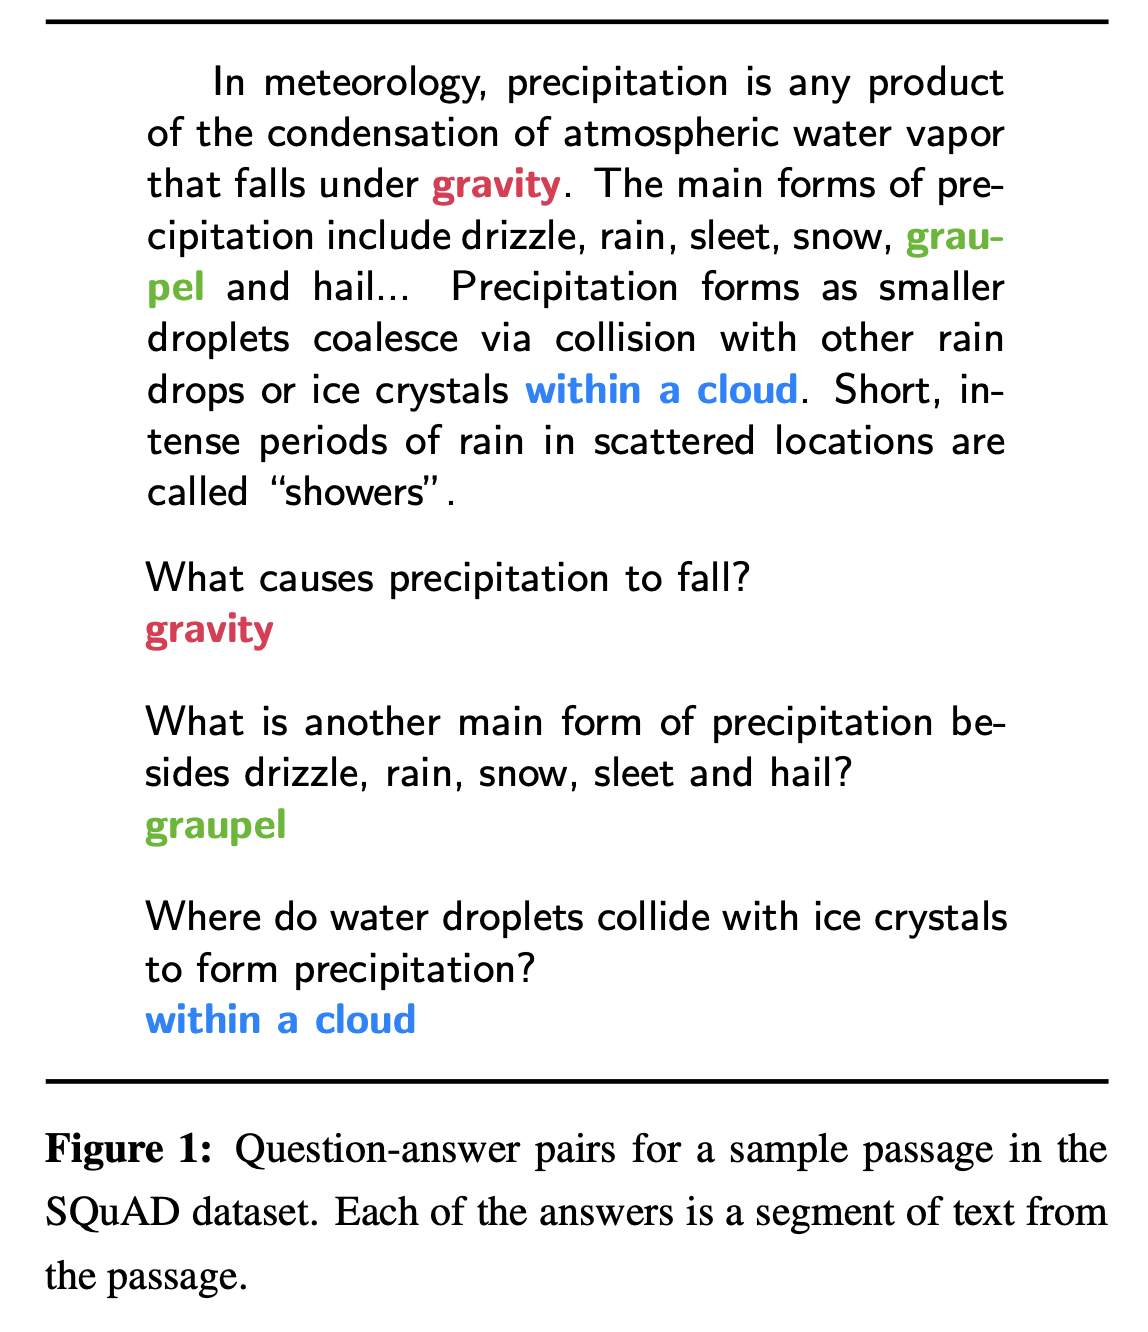

In [2]:
!pip install datasets

In [3]:
#Let first import all the libraries we need
!pip install datasets

from transformers import DistilBertTokenizerFast, DistilBertModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, Subset
from datasets import load_dataset, load_metric
from sklearn.model_selection import train_test_split
import string
import re
from tqdm import tqdm
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
get_device()

/opt/anaconda3/envs/kai_base/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda:0'

# Task and dataset

Let's first download the dataset

In [4]:
datasets = load_dataset("squad_v2")

The `datasets` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training and validation. We will split training into training set and the development set and use validation set for testing.

In [5]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [6]:
datasets['train']

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 130319
})

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing).

In [7]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [8]:
show_random_elements(datasets["train"])

,id,title,context,question,answers
0,5ad2f584604f3c001a3fda59,Anthropology,"Ethnohistory is the study of ethnographic cultures and indigenous customs by examining historical records. It is also the study of the history of various ethnic groups that may or may not exist today. Ethnohistory uses both historical and ethnographic data as its foundation. Its historical methods and materials go beyond the standard use of documents and manuscripts. Practitioners recognize the utility of such source material as maps, music, paintings, photography, folklore, oral tradition, site exploration, archaeological materials, museum collections, enduring customs, language, and place names.",What does ethnohistory form the foundation for?,"{'text': [], 'answer_start': []}"
1,5726b8785951b619008f7bcd,Nutrition,"The list of nutrients that people are known to require is, in the words of Marion Nestle, ""almost certainly incomplete"". As of 2014, nutrients are thought to be of two types: macro-nutrients which are needed in relatively large amounts, and micronutrients which are needed in smaller quantities. A type of carbohydrate, dietary fiber, i.e. non-digestible material such as cellulose, is required, for both mechanical and biochemical reasons, although the exact reasons remain unclear. Other micronutrients include antioxidants and phytochemicals, which are said to influence (or protect) some body systems. Their necessity is not as well established as in the case of, for instance, vitamins.",In which year were nutrients categorized into their two respective categories?,"{'text': ['2014'], 'answer_start': [127]}"
2,572806282ca10214002d9bda,Pope_John_XXIII,"On 10 May 1963, John XXIII received the Balzan Prize in private at the Vatican but deflected achievements of himself to the five popes of his lifetime, Pope Leo XIII to Pius XII. On 11 May, the Italian President Antonio Segni officially awarded Pope John XXIII with the Balzan Prize for his engagement for peace. While in the car en route to the official ceremony, he suffered great stomach pains but insisted on meeting with Segni to receive the award in the Quirinal Palace, refusing to do so within the Vatican. He stated that it would have been an insult to honour a pontiff on the remains of the crucified Saint Peter. It was the pope's last public appearance.",Who officially awarded the pope the Balzan Prize?,"{'text': ['Italian President Antonio Segni'], 'answer_start': [194]}"
3,57097f32ed30961900e84224,Orthodox_Judaism,"According to the New Jersey Press Association, several media entities refrain from using the term ""ultra-Orthodox"", including the Religion Newswriters Association; JTA, the global Jewish news service; and the Star-Ledger, New Jersey’s largest daily newspaper. The Star-Ledger was the first mainstream newspaper to drop the term. Several local Jewish papers, including New York's Jewish Week and Philadelphia's Jewish Exponent have also dropped use of the term. According to Rabbi Shammai Engelmayer, spiritual leader of Temple Israel Community Center in Cliffside Park and former executive editor of Jewish Week, this leaves ""Orthodox"" as ""an umbrella term that designates a very widely disparate group of people very loosely tied together by some core beliefs.""",What term do media entities refrain from using?,"{'text': ['""ultra-Orthodox'], 'answer_start': [98]}"
4,5acd0cc307355d001abf3258,Arsenal_F.C.,"In 1933, Herbert Chapman, wanting his players to be more distinctly dressed, updated the kit, adding white sleeves and changing the shade to a brighter pillar box red. Two possibilities have been suggested for the origin of the white sleeves. One story reports that Chapman noticed a supporter in the stands wearing a red sleeveless sweater over a white shirt; another was that he was inspired by a similar outfit worn by the cartoonist Tom Webster, with whom Chapman played golf. Regardless of which story is true, the red and white shirts have come to define Arsenal and the team have w

## TODO 1: Initial Data Observation
Please make at least 5 observations about the training dataset, including but not limtied to total number of articles, total number of unanswerable question, and the average size of answer spans

In [9]:
#TOD0 1

## TODO 2: Preprocessing Dataset

Fillout the impelementation `read_data` and `add_token_positions`. We will subsample the dataset size for shorter training time

In [32]:
random_sampler = RandomSampler(datasets['train'], num_samples=int(0.3 * len(datasets['train'])))
train_subset = Subset(datasets['train'], list(random_sampler))
random_sampler = RandomSampler(datasets['validation'], num_samples=int(0.3 * len(datasets['validation'])))
test_subset = Subset(datasets['train'], list(random_sampler))

In [33]:
def read_data(data):
    '''
    This function reads the data and returns the context, question and answer

    Args:
        Data (Dataset): data to be read

        Returns:
            context (list): List of contexts
            question (list): List of questions
            answer (list): List of answers {"text":.., "start_index":.., "end_index":.., "possible":..}, if the question is not answerable, both of them should be 0.
    '''

    #raise NotImplementedError
    data_contexts = [] #one context/paragraph for an element
    data_questions = [] # a set of questions for a context for an element
    data_answers = [] # a set of [probs(everyword in the answer span has probability of one)]
    for question in data:
      context = question['context']
      q, a = question['question'], question['answers']
      data_contexts.append(context)
      data_questions.append(q)
      if (len(a['text'])==0):
        data_answers.append({'answer_start': 0, 'answer_end': 0})
      else:
        start_index = a['answer_start'][0]
        end_index = start_index+len(a['text'][0])
        data_answers.append({'answer_start': start_index, 'answer_end': end_index, 'text': a['text']})
    return data_contexts, data_questions, data_answers

In [34]:
train_contexts, train_questions, train_answers = read_data(train_subset)
train_contexts, val_contexts, train_questions, val_questions, train_answers, val_answers = train_test_split(train_contexts, train_questions, train_answers, test_size=0.2)
test_contexts, test_questions, test_answers = read_data(test_subset)

In [67]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True, return_tensors = 'pt')
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True, return_tensors = 'pt')
test_encodings = tokenizer(test_contexts, test_questions, truncation=True, padding=True, return_tensors = 'pt')

In [68]:
def add_token_positions(encodings, answers):
    '''
    This function adds the token positions to the encodings. You have to convert character positions to token positions.
    Hints: You can use encodings.char_to_token method to get the token position and handle the case when the answer is truncated from the context.
    Args:
        encodings (a list of dict): Encodings of context and question
        answers (list): List of answers

    Returns:
        encodings (a list of dict): Encodings of the data with additiona dict fields that indicate start token and end positions
    '''

    start_positions = []
    end_positions = []
    text = []
    for i in range(len(answers)):
      if (answers[i]['answer_start']==answers[i]['answer_end']==0 or answers[i]['answer_start']>answers[i]['answer_end']):
        start_positions.append(0)
        end_positions.append(0)
        text.append("")
      else:
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']-1))
        #print(encodings.char_to_token(i, answers[i]['answer_start']),encodings.char_to_token(i, answers[i]['answer_end']-1) )
        text.append(answers[i]['text'][0])
      if start_positions[-1] is None:
        start_positions[-1] = tokenizer.model_max_length - 1
      if end_positions[-1] is None:
        end_positions[-1] = tokenizer.model_max_length - 1
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    return text

In [69]:
train_text = add_token_positions(train_encodings, train_answers)
val_text = add_token_positions(val_encodings, val_answers)
test_text = add_token_positions(test_encodings, test_answers)

In [70]:
class SQUADDataset(Dataset):
    '''
    This class is the dataset class for SQUAD dataset. It return a dictionary with keys of the encodings. Each value in the dictionary is a tensor.
    '''
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        map = {}
        for key, val in train_encodings.items():
          map[key] = torch.tensor(val[idx])
        return map
    def __len__(self):
        return len(self.encodings.input_ids)

In [71]:
train_dataset = SQUADDataset(train_encodings)
val_dataset = SQUADDataset(val_encodings)
test_dataset = SQUADDataset(test_encodings)

# Model Implementation

Now, we will implement our model. We will use DistilBERT as our backbome pretrained laungage model for efficiency. DistilBERT is a transformer model with smaller parameters that is distiled from BERT. The simplest way to finetune DistilBERT model on SQUAD2.0 is to first get the contextual representation of context + question and have linear layers on top of the hidden-states output to compute start logits and end logits.

In [20]:
class BERTForQuestionAnswering(nn.Module):
    '''
    This class is the BERT model for question answering. It returns the start and end logits.
    #test one data point
    '''
    def __init__(self):
        super(BERTForQuestionAnswering, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.qa_outputs = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        '''
        params:
          input_ids: Tensor of (Batch Size, Length)
          attention_mask: Tensor of (Batch Size, Length)
        returns:
          start_logits: Tensor of (Batch Size, Length)
          end_logits: Tensor of (Batch Size, Length)
        '''
        outputs = self.bert(input_ids = input_ids, attention_mask = attention_mask)
        logits = self.qa_outputs(outputs[0])
        start_logits, end_logits = logits.split(1, dim=2)
        return start_logits.squeeze(2), end_logits.squeeze(2)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=8)
temp = next(iter(train_loader))
model = BERTForQuestionAnswering().to(get_device())
model(temp['input_ids'].to(get_device()), temp['attention_mask'].to(get_device()))

/tmp/ipykernel_3441247/3672014005.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  map[key] = torch.tensor(val[idx])


(tensor([[ 0.6825,  0.1654,  0.0917,  ...,  0.1775,  0.2445,  0.2574],
         [ 0.4510, -0.1206,  0.0907,  ...,  0.0220, -0.0613,  0.0961],
         [ 0.7695,  0.3506,  0.4586,  ...,  0.3200,  0.3635,  0.3340],
         ...,
         [ 0.5546,  0.2028,  0.0877,  ...,  0.2086,  0.2063,  0.1529],
         [ 0.5744, -0.1297, -0.0897,  ...,  0.1146,  0.0901,  0.1445],
         [ 0.6316,  0.2779,  0.1049,  ...,  0.1619,  0.2757,  0.2349]],
        device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor([[ 1.0923e-01,  1.2421e-01,  2.4240e-01,  ...,  1.2183e-01,
           2.6444e-02,  6.9481e-02],
         [ 4.3527e-02,  2.3489e-01,  2.5891e-01,  ..., -7.4989e-02,
          -1.9053e-02, -5.1275e-02],
         [ 1.3236e-01,  4.0943e-01,  1.3634e-01,  ...,  1.5240e-01,
           6.4685e-02,  7.0150e-02],
         ...,
         [-1.0701e-04, -3.4421e-02,  2.8934e-02,  ..., -1.5289e-01,
          -1.1748e-01, -7.3363e-02],
         [ 2.2966e-01,  5.8363e-02,  2.9546e-01,  ...,  1.2139e-01,
   

# Training

After we implement our model, we will use our training data to finetune the model. Specifically, we will use AdamW as our optimization algorithm and CrossEntropy as our loss function. Beside training, we also have to evaluate the model's performance on validation dataset and test dataset. There are two metrics to measure the performance: exact matching (the predicted answer span need to exact as the grouth truth answer span) and f1-score (the overlap between the predicted answer and ground truth answer). One epoch takes about 1 hour to run, and 2-3 epoch of training should give you exact match score of 0.6 and f1-score of 0.7.

In [22]:
# Some potentially useful helper functions for the metrics
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

In [23]:
# metric implementation here
def compute_exact(a_gold, a_pred):
    return (get_tokens(a_gold) == get_tokens(a_pred))

def compute_f1(a_gold, a_pred):
    if (a_gold == a_pred == ""):
      return 1
    a_gold = get_tokens(a_gold)
    a_pred = get_tokens(a_pred)
    if (len(a_gold)==0 or len(a_pred)==0):
      # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
      return int(a_gold == a_pred)
    matched = len(list(set(a_gold).intersection(a_pred)))
    p = matched / len(a_pred)
    r = matched / len(a_gold)
    if matched == 0:
      return 0
    f1 = 2 * (p * r) / (p + r)
    return f1

In [24]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    '''
    This function is the training loop of the model. It prints the training loss and validation loss for each epoch.
    '''
    #raise NotImplementedError
    train_loss = 0
    for epoch in range(num_epochs):
        model.train()
        for batch in tqdm(train_loader, leave=False, desc="Training Batches"):
            optimizer.zero_grad()
            #Your code here
            input_ids = batch['input_ids'].to(get_device())
            attention_masks =batch['attention_mask'].to(get_device())
            start_label = batch['start_positions'].to(get_device())
            end_label = batch['end_positions'].to(get_device())
            pred_start, pred_end = model(input_ids, attention_masks)
            loss = loss_fn(pred_start,start_label) + loss_fn(pred_end, end_label)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')
        exact, f1_score, val_loss = evaluate(model, val_loader)
        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Exact: {exact}, f1_score: {f1_score}, Validation Loss: {val_loss}')

In [110]:
def evaluate(model, val_loader):
    '''
    This function evaluates the model on the validation set.

    Returns:
      exact_match: a score indicates the accuracy of the model on answering the questions exactly
      f1: the average f1_score of the model on each question
      loss: the total validation loss
    '''
    preds, golds = [], []
    model.eval()
    exact = f1= total = 0
    val_loss = 0
    for batch in tqdm(val_loader, leave=False, desc="Validation Batches"):
        #Your code here
        input_ids = batch['input_ids'].to(get_device())
        attention_masks =batch['attention_mask'].to(get_device())
        start_label = batch['start_positions'].to(get_device())
        end_label = batch['end_positions'].to(get_device())
        pred_start, pred_end = model(input_ids, attention_masks)
        loss = loss_fn(pred_start, start_label) + loss_fn(pred_end,end_label)
        val_loss += loss.item()
        ls = nn.LogSoftmax(dim=1)
        pred_start, pred_end = ls(pred_start), ls(pred_end)
        start_label, end_label = start_label.to("cpu").cpu().numpy(), end_label.to("cpu").cpu().numpy()
        for i in range(len(input_ids)):
          total += 1
          tokens = tokenizer.convert_ids_to_tokens(input_ids[i])
          _, start_index = torch.max(pred_start[i],0)
          _, end_index = torch.max(pred_end[i],0)
          start_gold, end_gold = start_label[i], end_label[i]
          label=""
          for j in tokens[start_gold:end_gold+1]:
            label+=j+" "
          pred=""
          for j in tokens[start_index:end_index+1]:
            pred+=j+" "
          
          exact += compute_exact(label, pred)
          f1+= compute_f1(label, pred)
          preds.append(pred)
          golds.append(label)
          # print(pred_start[i].argmax())
          # print(f"Pred: {pred}, Gold: {label}")
    return exact / total, f1 / total, val_loss

In [106]:
random_sampler = RandomSampler(train_dataset, num_samples = 16)
train_subset = Subset(train_dataset, list(random_sampler))

In [111]:
train_loader = DataLoader(train_dataset, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
model = BERTForQuestionAnswering().to(get_device())
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-5)
train(model, train_loader, val_loader, loss_fn, optimizer, 3)

Training Batches:   0%|          | 0/3910 [00:00<?, ?it/s]/tmp/ipykernel_3441247/3672014005.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  map[key] = torch.tensor(val[idx])


Epoch 1/3, Training Loss: 3.8507480441799857


Epoch 1/3, Exact: 0.40120219976979155, f1_score: 0.49382099884015307, Validation Loss: nan


Epoch 2/3, Training Loss: 2.0253781439957343


Epoch 2/3, Exact: 0.4898324593937844, f1_score: 0.5608928743325414, Validation Loss: nan


Epoch 3/3, Training Loss: 1.2487725955834599


Epoch 3/3, Exact: 0.549302979920706, f1_score: 0.5991135085034089, Validation Loss: nan


In [112]:
evaluate(model, test_loader)

Validation Batches:   0%|          | 0/446 [00:00<?, ?it/s]/tmp/ipykernel_3441247/3672014005.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  map[key] = torch.tensor(val[idx])


(0.5518112889637742, 0.60454005211225, 397.24278053981834)